<a href="https://colab.research.google.com/github/Abhishek-chohan/Hackerearth_pet_adoption_competition/blob/master/First_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
# load the train set of the MNIST dataset
(X_train, _), _ = tf.keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

11493376/11490434 [==============================] - 0s 0us/step


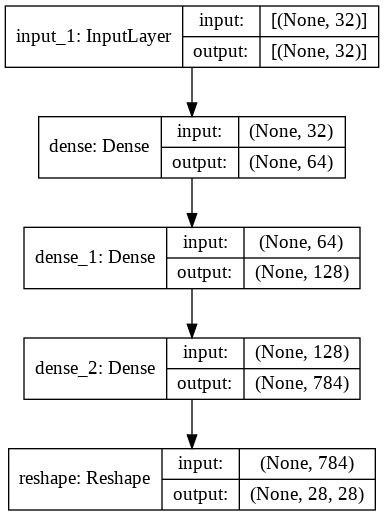

In [ ]:
random_normal_dimensions = 32
inputs = tf.keras.layers.Input(shape = [random_normal_dimensions])
x = tf.keras.layers.Dense(64,activation = 'selu')(inputs)
x = tf.keras.layers.Dense(128,activation = 'selu')(x)
x = tf.keras.layers.Dense(28*28,activation = 'sigmoid')(x)
x = tf.keras.layers.Reshape(target_shape=(28,28))(x)
generator = tf.keras.Model(inputs = inputs,outputs = x)
plot_model(generator,show_shapes = True,show_layer_names = True)

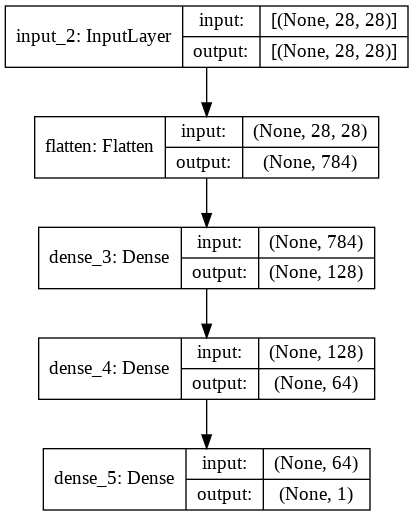

In [ ]:
inputs_d = tf.keras.layers.Input(shape = (28,28))
d = tf.keras.layers.Flatten()(inputs_d)
d = tf.keras.layers.Dense(128,activation = 'selu')(d)
d = tf.keras.layers.Dense(64,activation = 'selu')(d)
d = tf.keras.layers.Dense(1,activation = 'sigmoid')(d)
discriminator = tf.keras.Model(inputs = inputs_d,outputs = d)
discriminator.compile(loss = tf.keras.losses.BinaryCrossentropy(),optimizer = 'rmsprop')
plot_model(discriminator,show_shapes = True,show_layer_names = True)

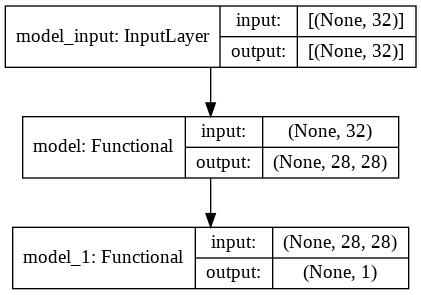

In [ ]:
gan = tf.keras.models.Sequential([generator,discriminator])
discriminator.trainable = False
gan.compile(loss = tf.keras.losses.BinaryCrossentropy(),optimizer = 'rmsprop')
plot_model(gan,show_shapes = True,show_layer_names = True)

In [ ]:

epochs = 100
generator,discriminator = gan.layers
for epoch in range(epochs):
  print("Epoch {}/{}".format(epoch + 1, epochs))   
  for real_images in dataset:
    batch_size = real_images.shape[0]
    noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])
    fake_images = generator(noise)
    mixed_images = tf.concat([fake_images,real_images],axis = 0)
    discriminator_labels = tf.constant([[0.]]* batch_size + [[1.]]* batch_size)
    discriminator.trainable = True
    discriminator.train_on_batch(mixed_images,discriminator_labels)
    
    noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])
    generator_labels = tf.constant([[1.]]*batch_size)
    discriminator.trainable = False
    gan.train_on_batch(noise,generator_labels)
  plot_multiple_images(fake_images, 8)                     
  plt.show()      

In [ ]:
## Deep gans
codings_size = 32

deep_gen = tf.keras.models.Sequential([
                                       tf.keras.layers.Dense(7*7*128,input_shape = [codings_size]),
                                       tf.keras.layers.Reshape(target_shape=(7,7,128)),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Conv2DTranspose(64,kernel_size=5,strides  = 2,padding = 'same',activation = 'selu'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Conv2DTranspose(1,kernel_size=5,strides = 2,padding = 'same',activation = 'tanh')
])

deep_disc = tf.keras.models.Sequential([
                                       tf.keras.layers.Conv2D(64,kernel_size = 5,strides = 2,input_shape = (28,28,1),padding = 'same',activation=tf.keras.layers.LeakyReLU(0.2)),
                                       tf.keras.layers.Dropout(0.4),
                                       tf.keras.layers.Conv2D(128,kernel_size = 5,strides = 2,padding = 'same',activation=tf.keras.layers.LeakyReLU(0.2)),
                                       tf.keras.layers.Dropout(0.4),
                                       tf.keras.layers.Flatten(),
                                       tf.keras.layers.Dense(1,activation='sigmoid')
                                       
])
deep_disc.compile(loss = tf.keras.losses.BinaryCrossentropy(),optimizer = 'rmsprop')
deep_gan = tf.keras.models.Sequential([deep_gen,deep_disc])
deep_disc.trainable = False
deep_gan.compile(loss = tf.keras.losses.BinaryCrossentropy(),optimizer = 'rmsprop')


In [ ]:
# download the training images
(X_train, _), _ = tf.keras.datasets.fashion_mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [ ]:
epochs = 100
deep_gen,deep_disc = deep_gan.layers
for epoch in range(epochs):
  print("Epoch {}/{}".format(epoch + 1, epochs))   
  for real_images in dataset:
    batch_size = real_images.shape[0]
    noise = tf.random.normal(shape = [batch_size,codings_size])
    fake_images = deep_gen(noise)
    mixed_images = tf.concat([fake_images,real_images],axis = 0)
    deep_disc_labels = tf.constant([[0.]]* batch_size + [[1.]]* batch_size)
    deep_disc.trainable = True
    deep_disc.train_on_batch(mixed_images,deep_disc_labels)
    
    noise = tf.random.normal(shape = [batch_size,codings_size])
    deep_gen_labels = tf.constant([[1.]]*batch_size)
    deep_disc.trainable = False
    deep_gan.train_on_batch(noise,deep_gen_labels)
  plot_multiple_images(fake_images, 16)                     
  plt.show()  

In [ ]:
inputs = tf.keras.layere.Input(shape = Input_shape)
x = tf.keras.layers.Convolution2DTranspose(512,kernel_size=4,strides = 1,padding = 'valid',use_bias = False)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Convolution2DTranspose(256,kernel_size=4,strides = 2,padding = 'same',use_bias = False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Convolution2DTranspose(128,kernel_size=4,strides = 2,padding = 'same',use_bias = False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Convolution2DTranspose(64,kernel_size=4,strides = 2,padding = 'same',use_bias = False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Convolution2DTranspose(3,kernel_size = 4,padding = 'same',strides = 2)(x)
x = tf.keras.layers.Activation('tanh')(x)




In [ ]:
inputs = tf.keras.layere.Input(shape = Input_shape)
x = tf.keras.layers.Conv2D(64,kernel_size = 4,strides = 2,padding = 'same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

x = tf.keras.layers.Conv2D(128,kernel_size = 4,strides = 2,padding = 'same',use_bias = False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

x = tf.keras.layers.Conv2D(256,kernel_size = 4,strides = 2,padding = 'same',use_bias = False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

x = tf.keras.layers.Conv2D(512,kernel_size = 4,strides = 2,padding = 'same',use_bias = False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)